# Corpus EDA

In [3]:
import pandas as pd
import random

import string 
import re
import wordcloud
from PIL import Image
from os import path

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [15]:
eng_stopwords_and_punct = stopwords.words('english') + list(string.punctuation) + ['’', '“','”', "''", '""', '', '..', '...', '``', '—', '->', '’ ’']

# TweetTokenizer will put all text in the tweet to lowercase, strip out usernames/handles and reduce reated chars in words
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) 

lemmatizer = WordNetLemmatizer()


def clean_tokenize_lemmatize_tweet(tweet):
    ''' 
    Apply text cleaning, tokenization then lemmatization on the given tweet 
    '''
    #remove urls
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    #remove RT 
    tweet = re.sub(r'^RT\s+', '', tweet)
    #remove the # symbol
    tweet = re.sub('#', '', tweet)
    #remove words containing numbers
    tweet = re.sub(r'\w*\d\w*', '', tweet)
    #tokenize
    tokens = tweet_tokenizer.tokenize(tweet)
    # remove stopwords and punctuation
    tokens = [token for token in tokens if token not in eng_stopwords_and_punct]
    # remove tokens that are only 1 char in length
    tokens = [token for token in tokens if len(token)>1]
    #lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens


def split_content_by_sentiment(region_df):
    '''
    Create dataframes for each sentiment class from the provided dataframe
    '''
    pos = region_df[region_df['sentiment'] == 'positive']['content']
    neg = region_df[region_df['sentiment'] == 'negative']['content']
    neu = region_df[region_df['sentiment'] == 'neutral']['content']
    return [pos, neg, neu]


def perform_topic_modeling_and_plot(content, topic_num, top_word_count, plot_title):
    '''
    Perform topic modeing using on the provided corpus and plot the top words 
    for the designated number of topics.
    '''
    cv = CountVectorizer(max_df=0.95, min_df=0.005, tokenizer=clean_tokenize_lemmatize_tweet, ngram_range=(1,2))
    lda = LatentDirichletAllocation(max_iter=10, learning_method='online', n_components=topic_num, random_state=42)

    # Unsupervised learning...no need to do a test/train split here ;)
    dtm = cv.fit_transform(content)

    # This might take awhile if you are dealing with a large amount of documents!
    lda.fit(dtm)
    # plot the top words per topic
    feature_names = cv.get_feature_names()
    num_rows = 2
    if topic_num == 20:
        num_rows = 4
    plot_top_words(lda, feature_names, top_word_count, plot_title, plot_num_rows=num_rows)


def plot_top_words(fitted_lda, feature_names, n_top_words, title, plot_num_rows):
    '''
    Plot the top words for the provided topic model|
    '''
    fig, axes = plt.subplots(plot_num_rows, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(fitted_lda.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5, color='blue', alpha=0.75)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 16})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.5)
    plt.show()

## Corpus Exploration: Topic Modeling

Now that we've assigned Sentiment to the Tweets, let's look into what people are tweeting about. I'm using unsupervised learning to perform Topic Modeling on each Sentiment group in the following way:
* Topics for Pos/Neg/Neu tweets from the entire United States 
* Topics for Pos/Neg/Neu tweets from the Southeast (this is the region where I currently live.) 
* Topics for Pos/Neg/Neu tweets from Alabama (this is the state where I currently live and most of my family members have children in k-12 in this state.) 

In [5]:
vetted_usa_tweets = pd.read_csv('../data/vetted_usa_tweets.csv')
southeast_tweets = vetted_usa_tweets[vetted_usa_tweets['region'] == 'Southeast']
alabama_tweets = southeast_tweets[southeast_tweets['loc_state'] == 'AL']

In [6]:
entire_us_sentiment_series = split_content_by_sentiment(vetted_usa_tweets)
se_sentiment_series = split_content_by_sentiment(southeast_tweets)
alabama_sentiment_series = split_content_by_sentiment(alabama_tweets)

### Text Processing to prep for Topic Modeling

Before performing topic modeling using LatentDirichletAllocation (LDA), I'll need apply some text processing. When I trained the Text Classifier to detect sentiment, punctuation and capitalization could actually be useful to the classifer, so I only did very light text processing to the corpus before trainging the classifier. With Topic Modeling, it is more important to normalize the corpus text so I'll apply the following text processing to prepare.

* Change to lowercase  (TweetTokenizer handles this)
* Remove RT and # (will need a regex)
* Remove urls (will need a regex)
* Remove stopwords and punctuation
* Peform lemmatization (after all other cleaning applied, apply lemmatization)

Text processing and Topic Modeling are peformed in the __clean_tokenize_lemmatize_tweet__ and the __perform_topic_modeling__ functions 


## Question 4: What are the Topics for Positive, Negative, and Neutral Tweets in the US, the Southeast Region, and the state of Alabama?

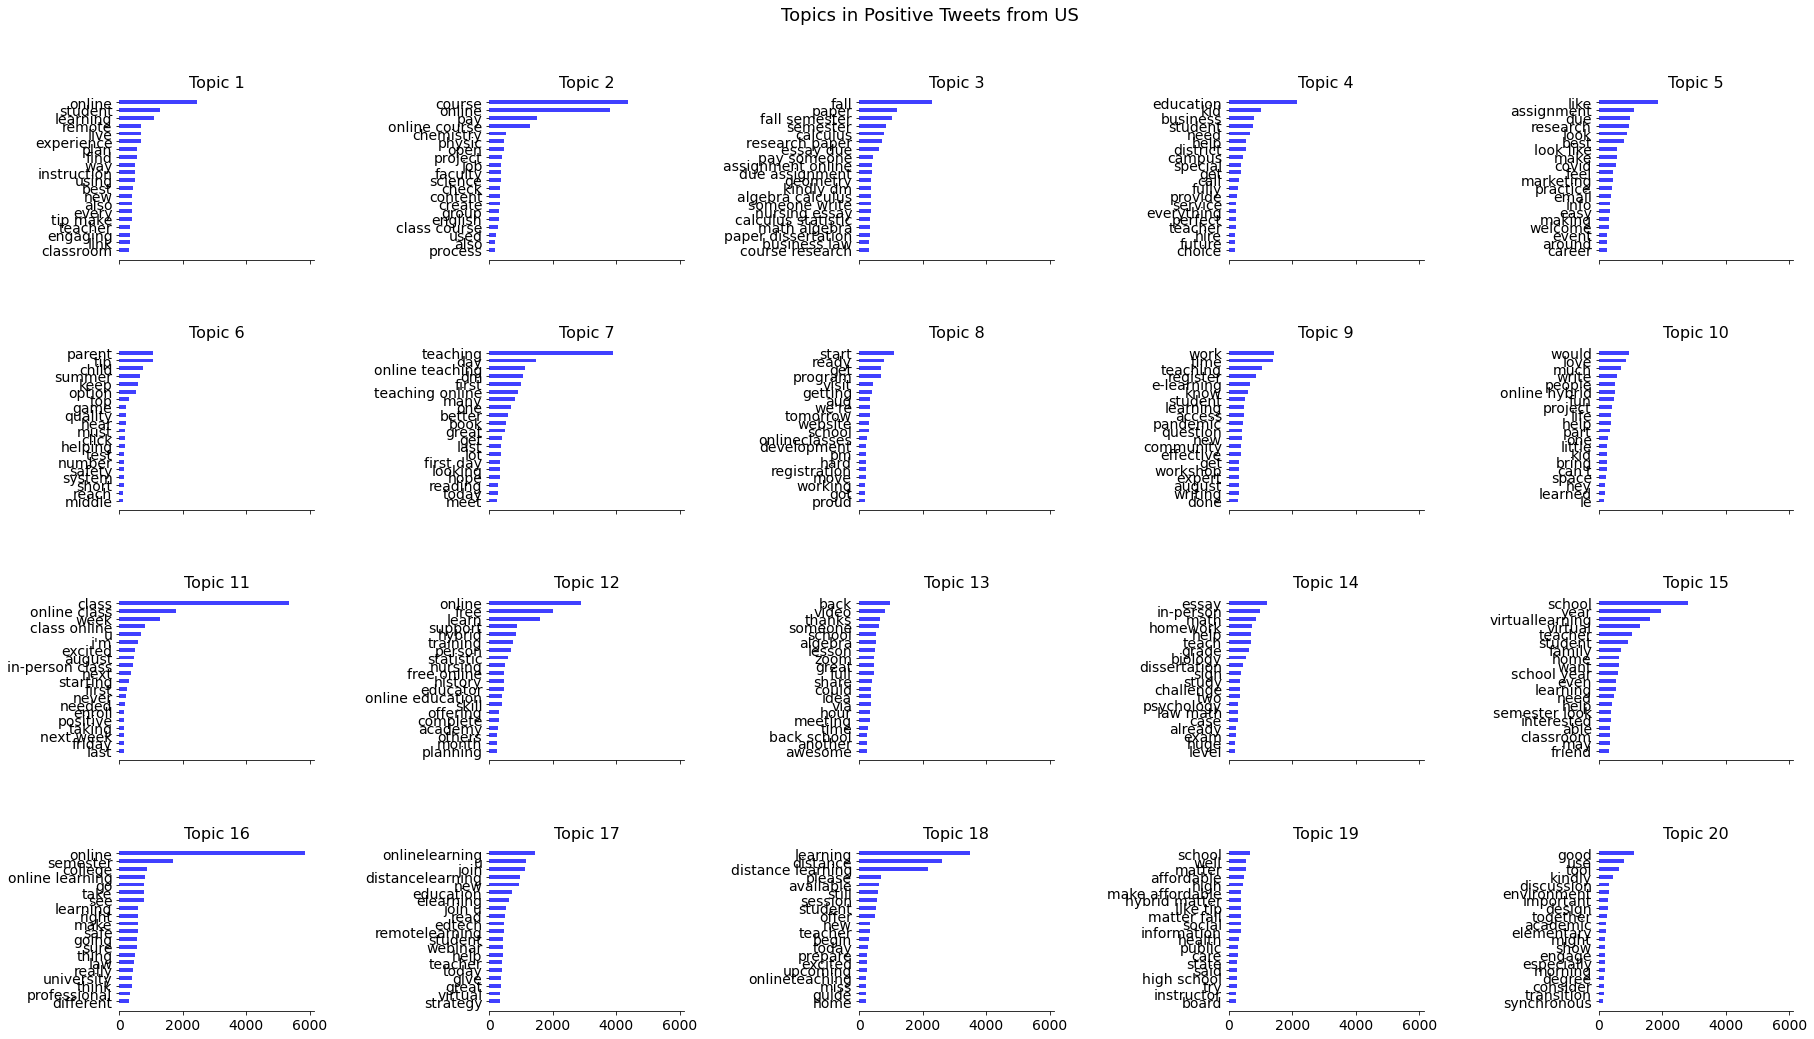

In [21]:
# US-wide Positive topic - Selecting 20 Topics instead of 10 as the Positive class was the majority class (73.9% of Tweets were Positive)
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[0], topic_num=20, top_word_count=20, plot_title='Topics in Positive Tweets from US')

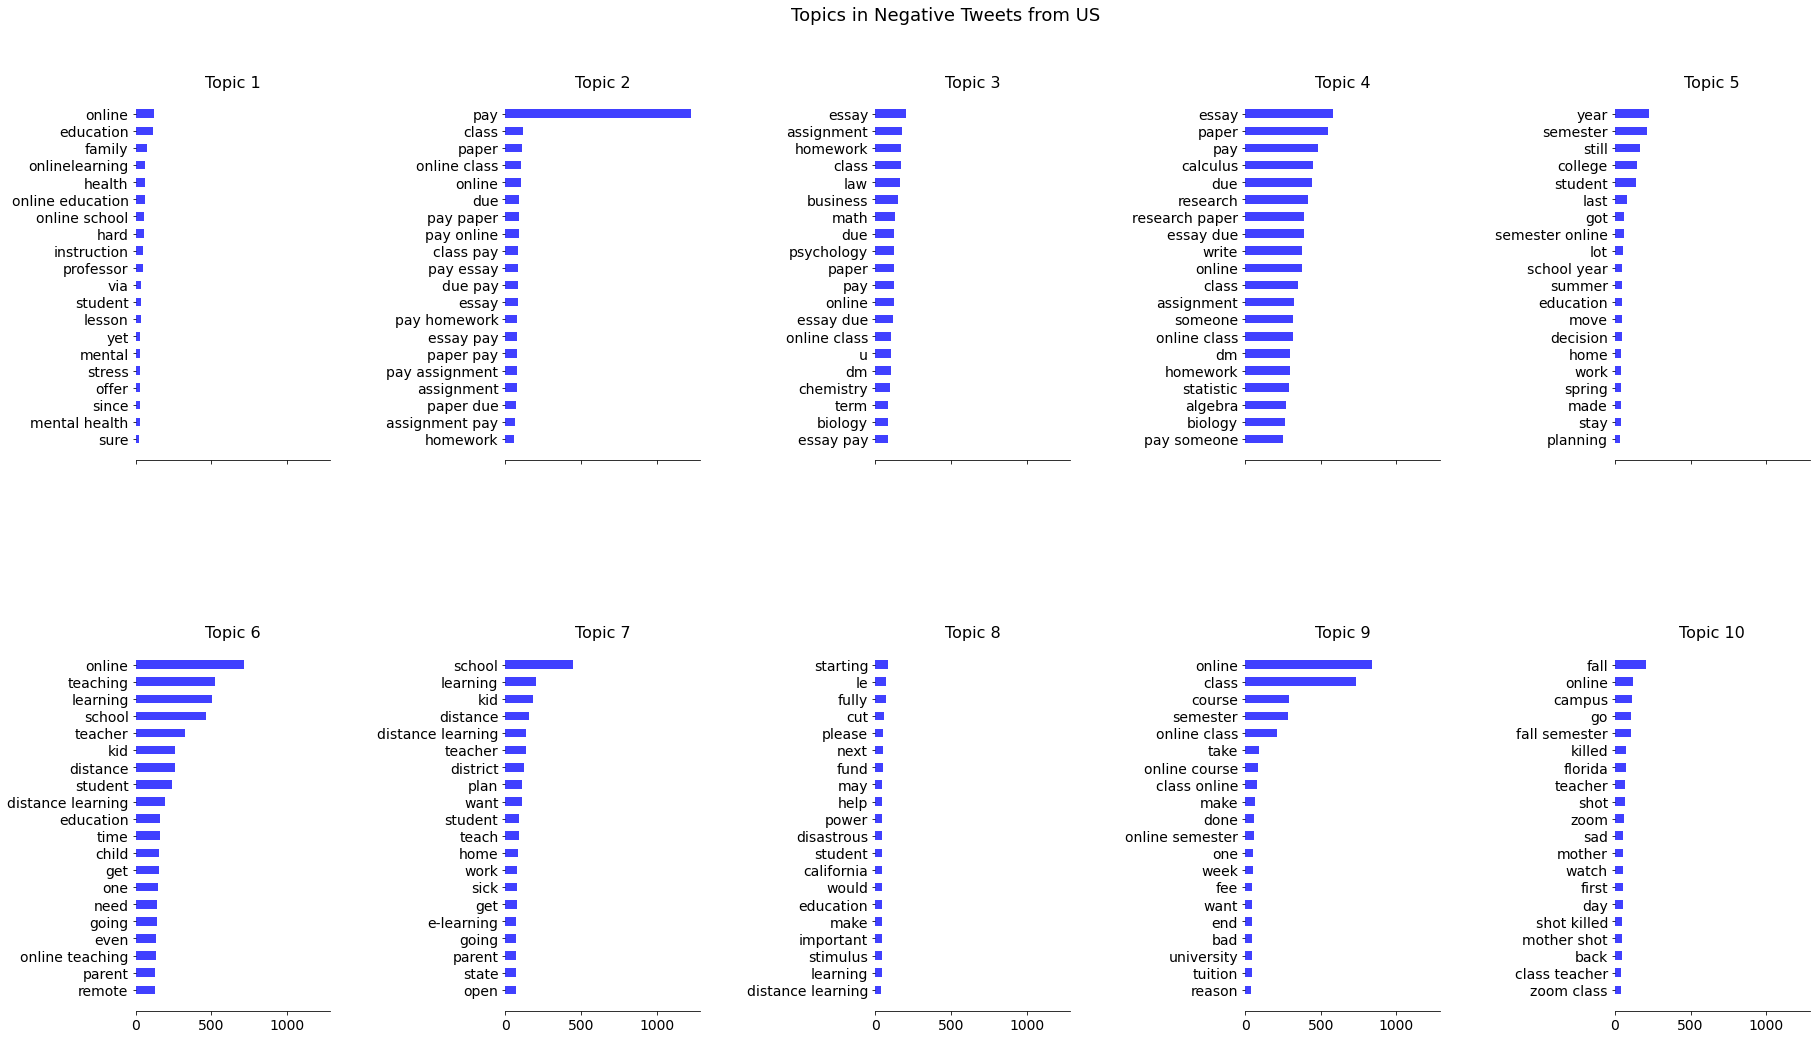

In [22]:
# US-wide Negative topics
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[1], topic_num=10, top_word_count=20, plot_title='Topics in Negative Tweets from US')

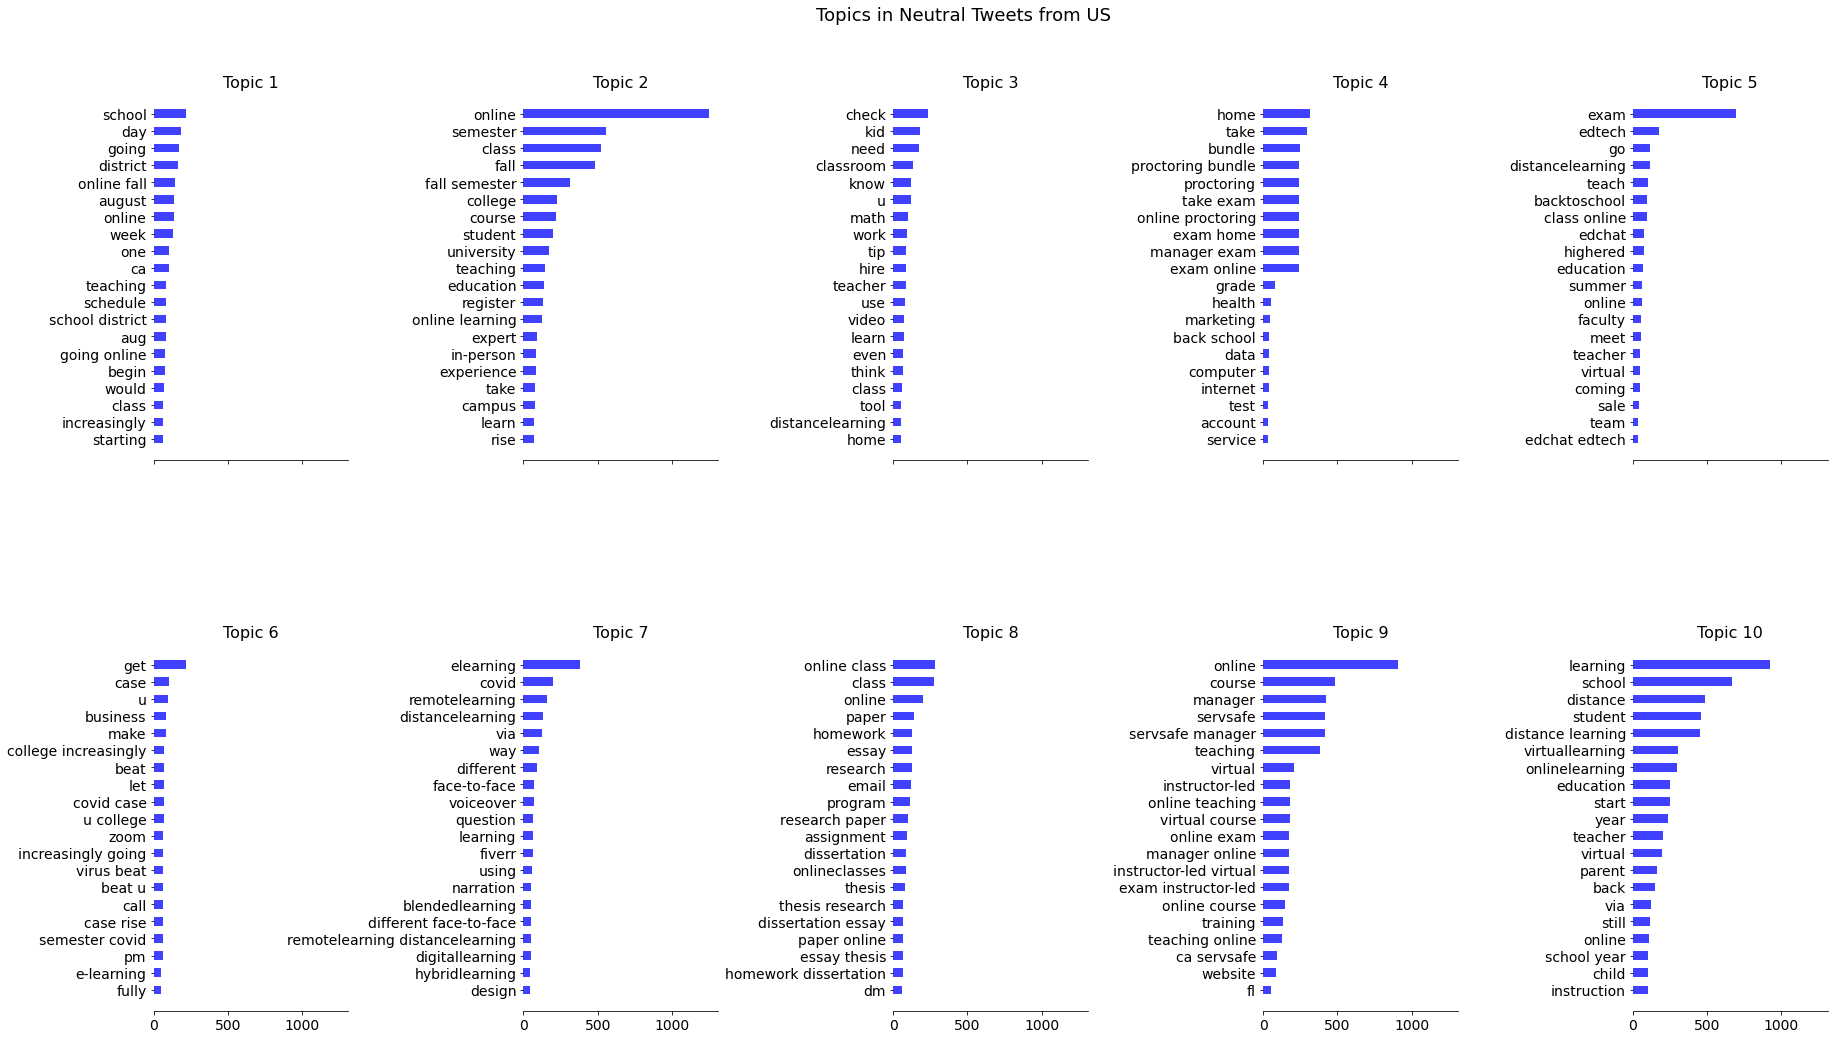

In [23]:
## US-wide Neutral topics
perform_topic_modeling_and_plot(content=entire_us_sentiment_series[2], topic_num=10, top_word_count=20, plot_title='Topics in Neutral Tweets from US')

### US Southeast Region

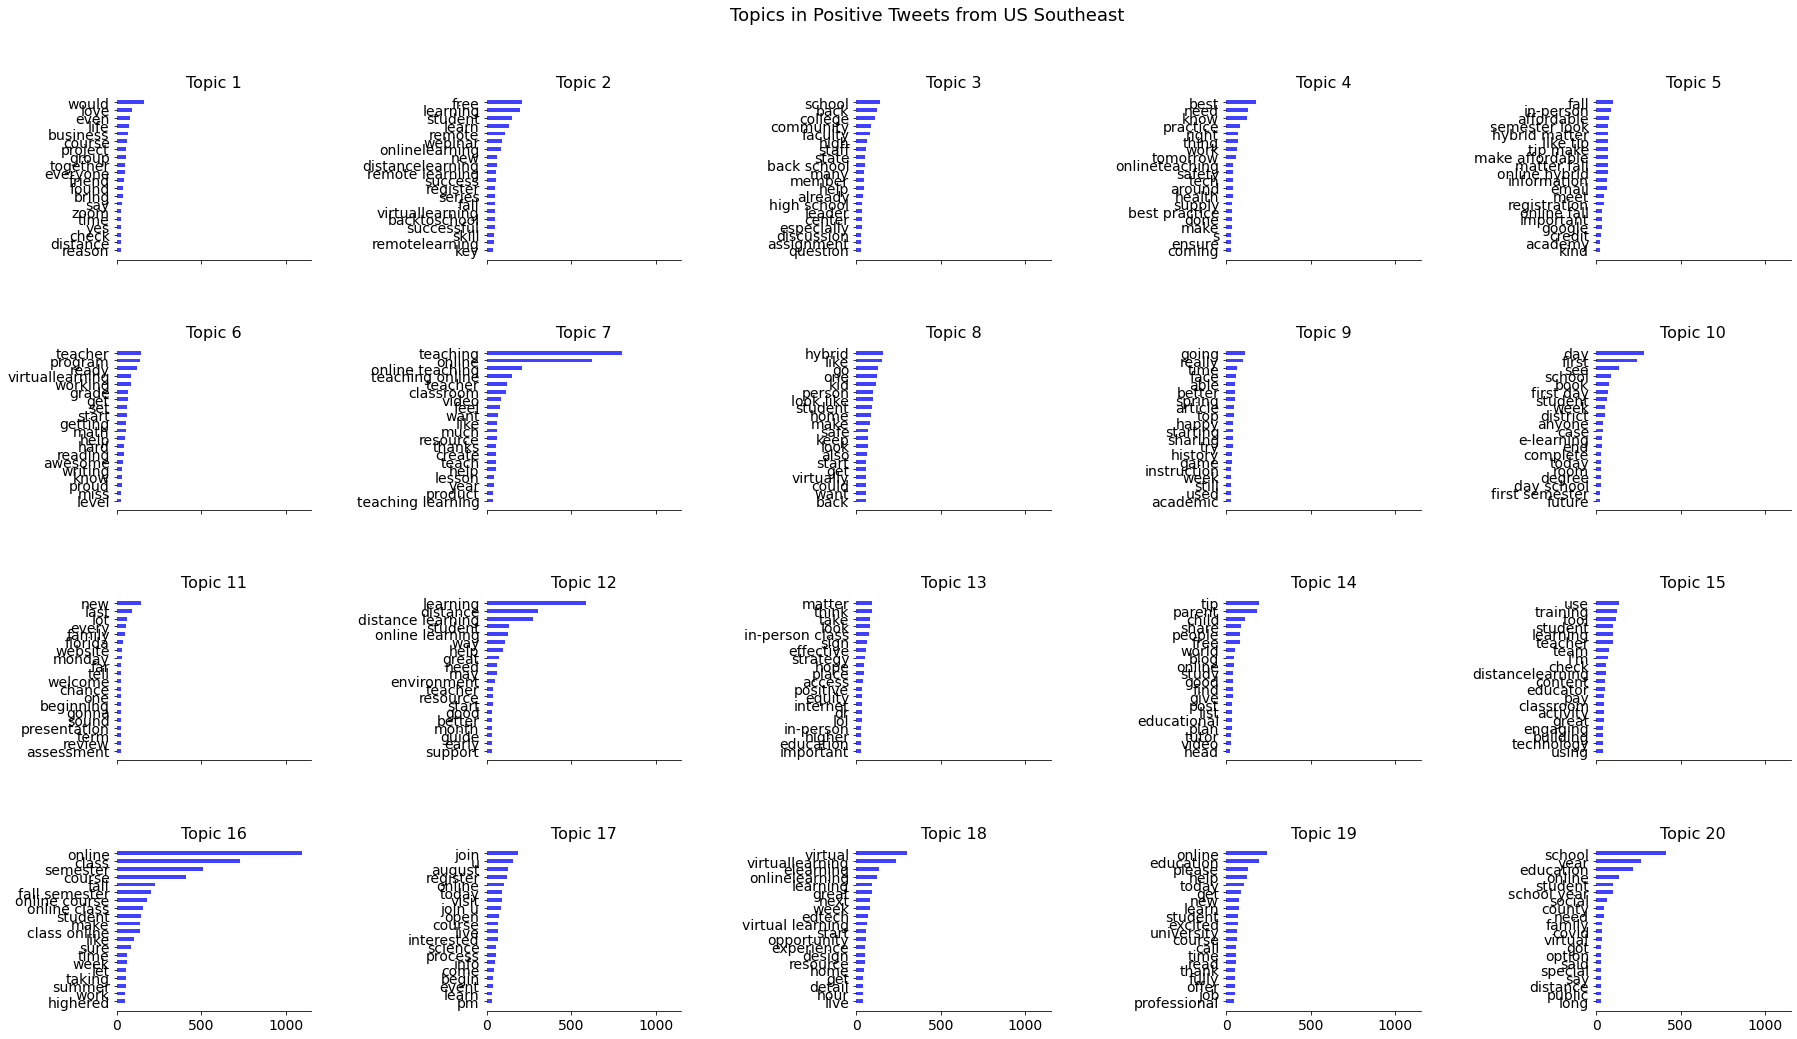

In [24]:
# Southeast Positive topics - Again, getting 20 Topics for the majority class: Positive
perform_topic_modeling_and_plot(content=se_sentiment_series[0], topic_num=20, top_word_count=20, plot_title='Topics in Positive Tweets from US Southeast')

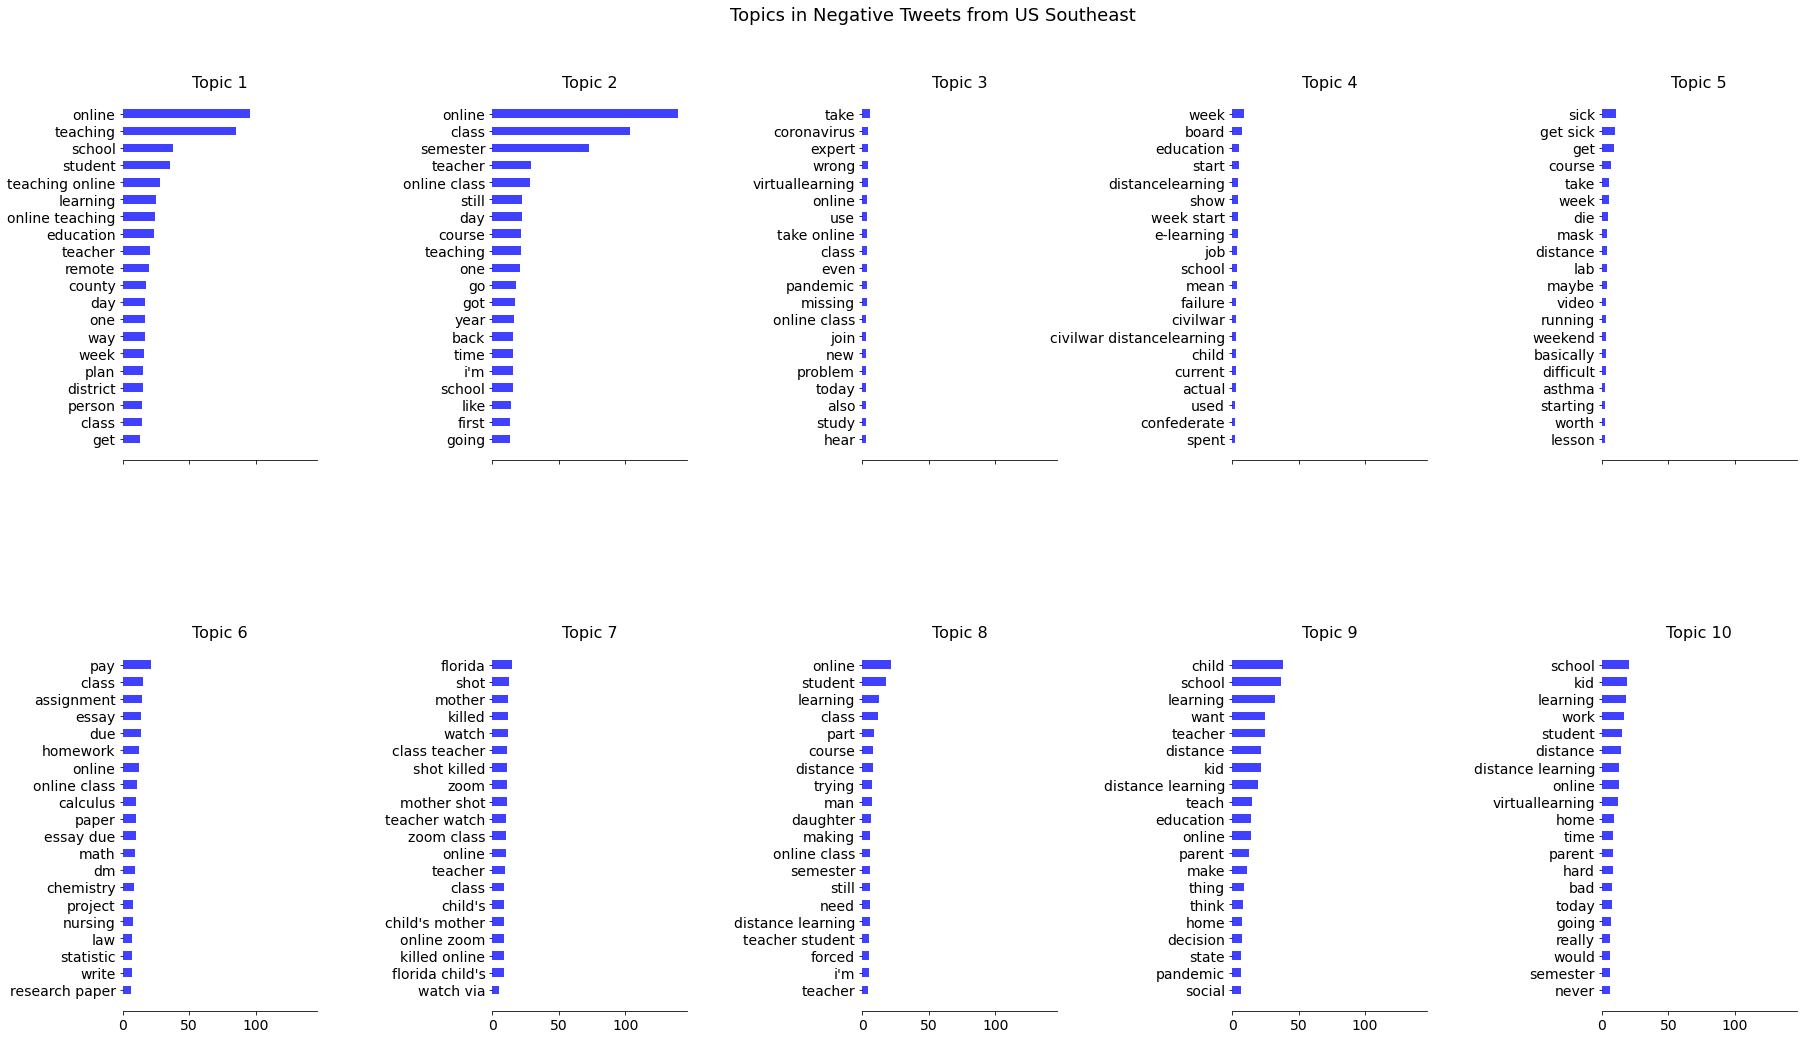

In [25]:
# Southeast Negative topics
perform_topic_modeling_and_plot(content=se_sentiment_series[1], topic_num=10, top_word_count=20, plot_title='Topics in Negative Tweets from US Southeast')

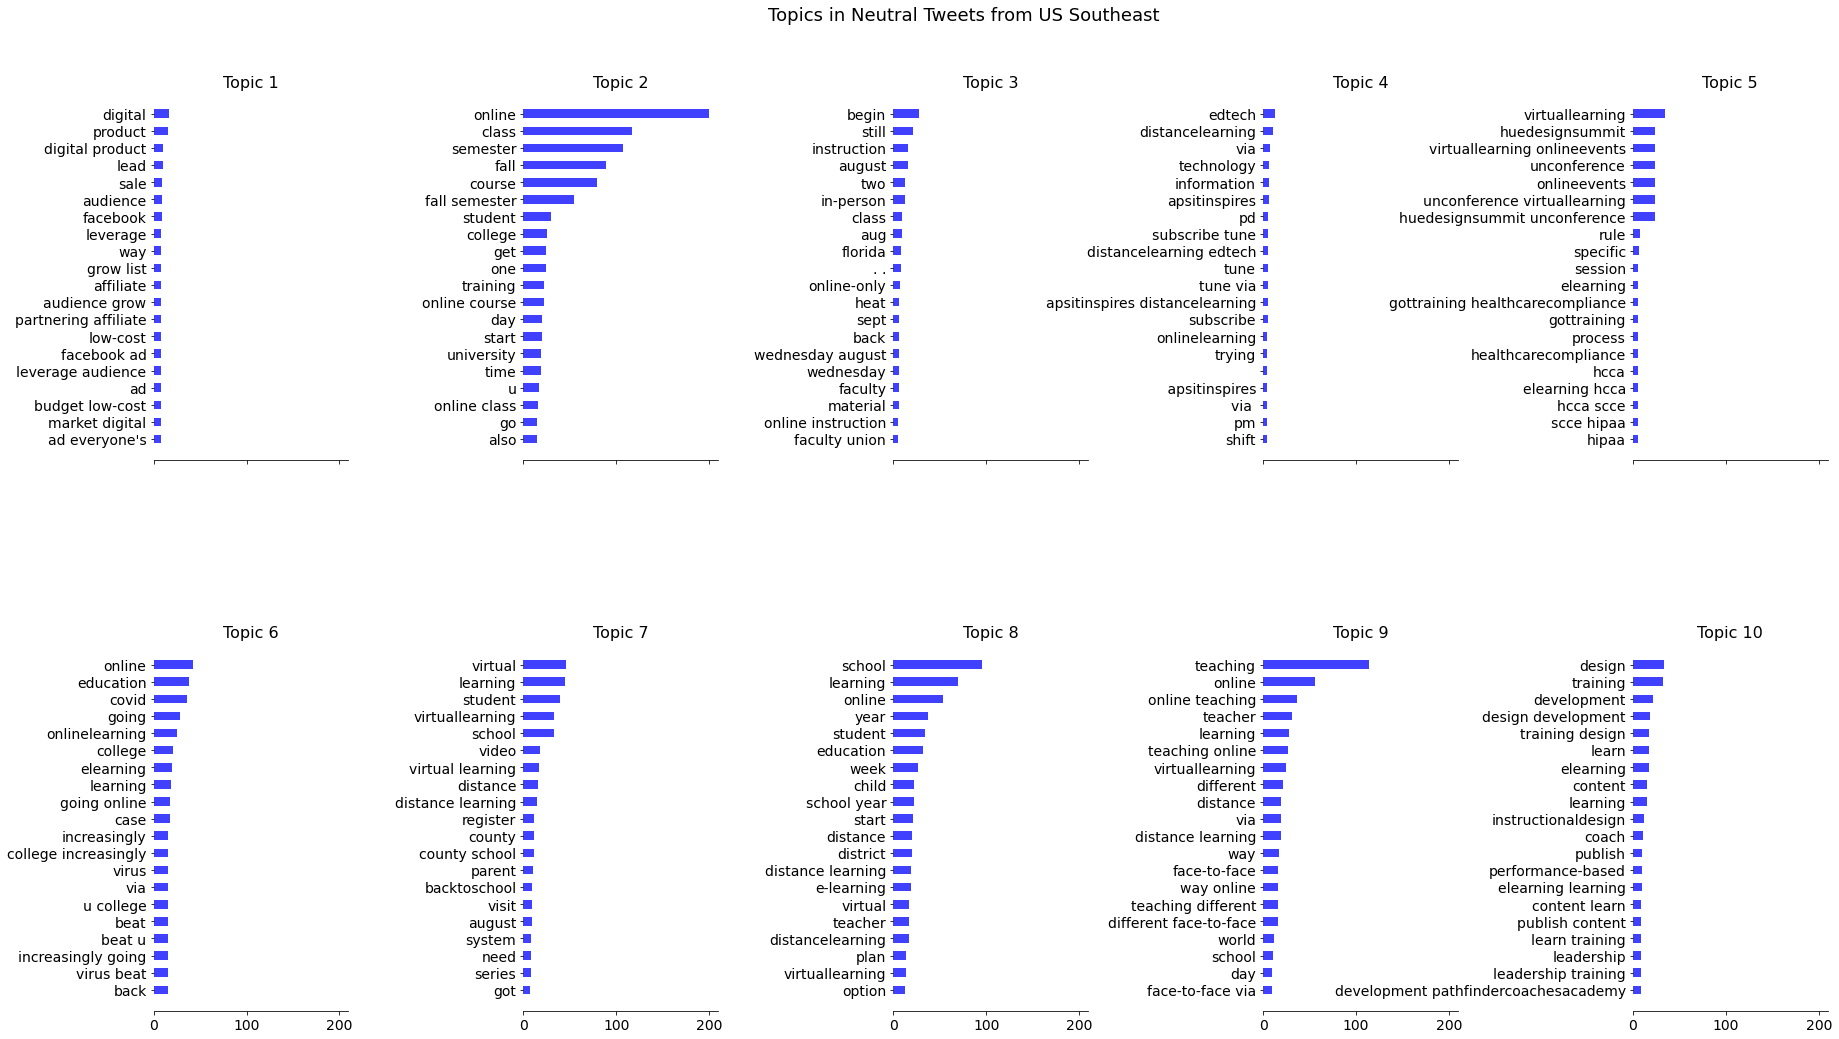

In [26]:
# Southeast Neutral topics
perform_topic_modeling_and_plot(content=se_sentiment_series[2], topic_num=10, top_word_count=20, plot_title='Topics in Neutral Tweets from US Southeast')

### Alabama

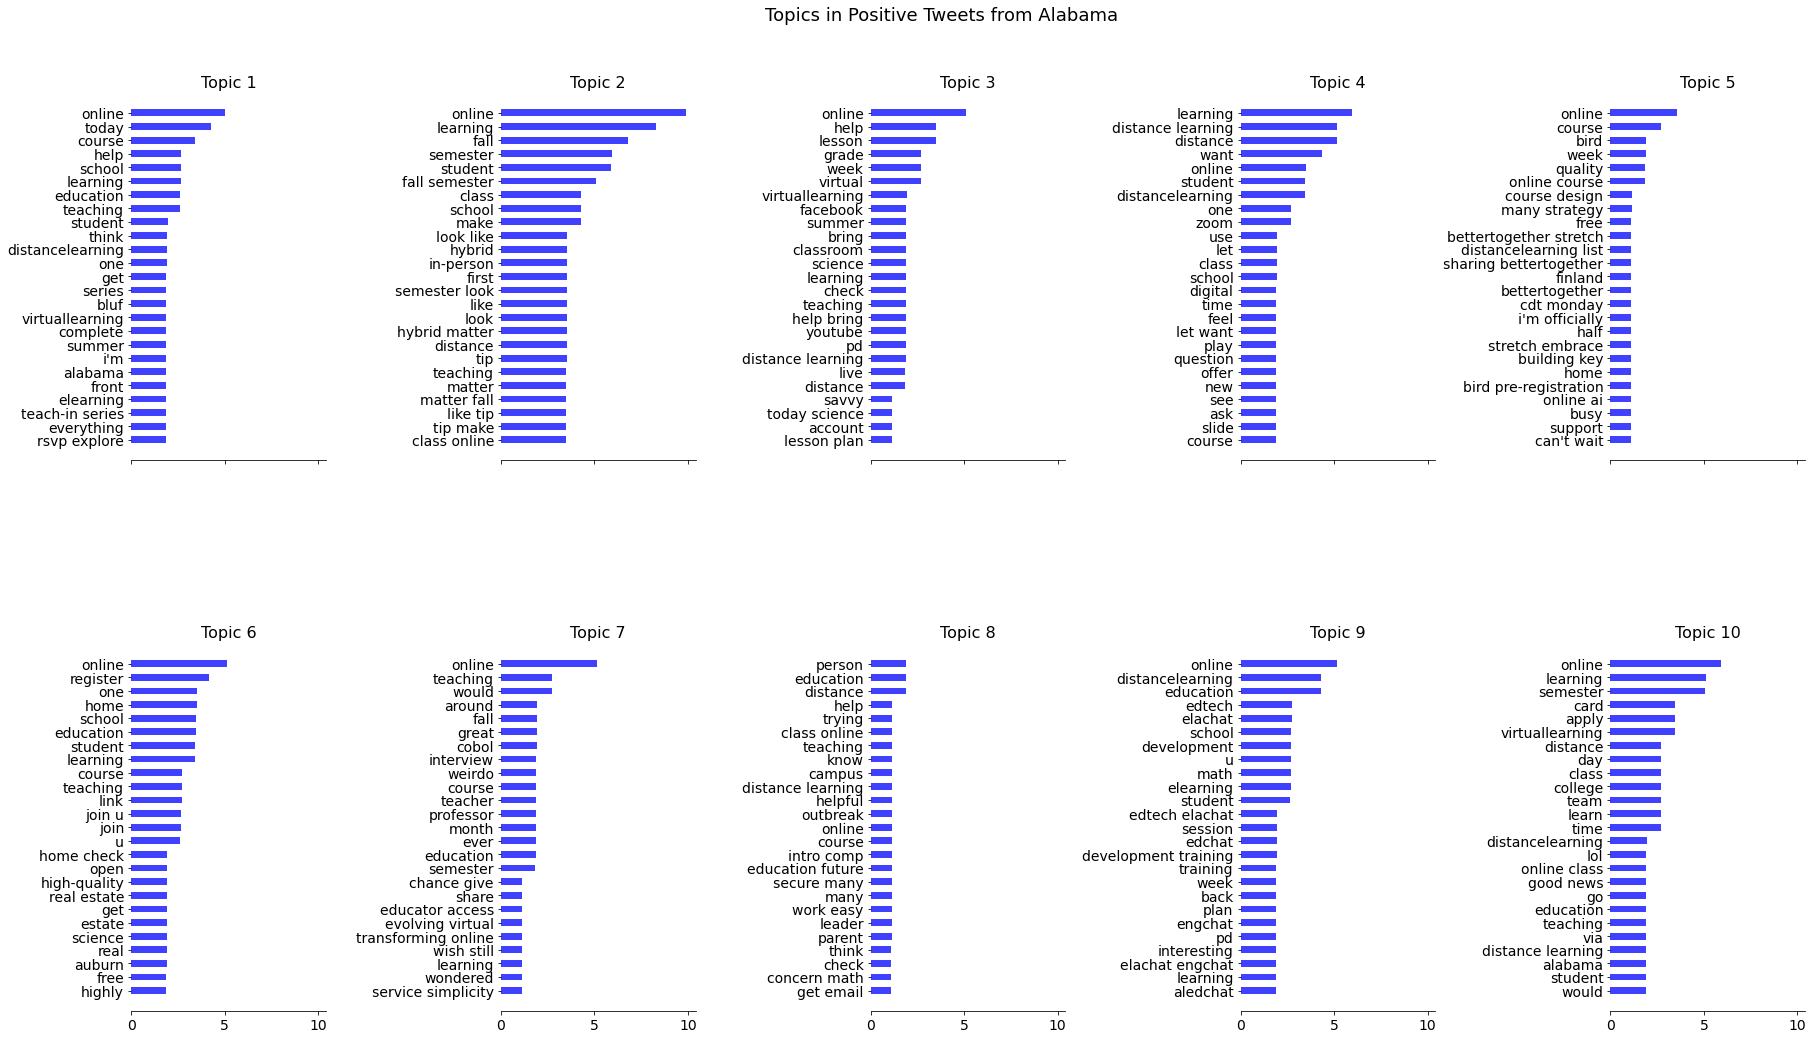

In [28]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[0], topic_num=10, top_word_count=25, plot_title='Topics in Positive Tweets from Alabama')

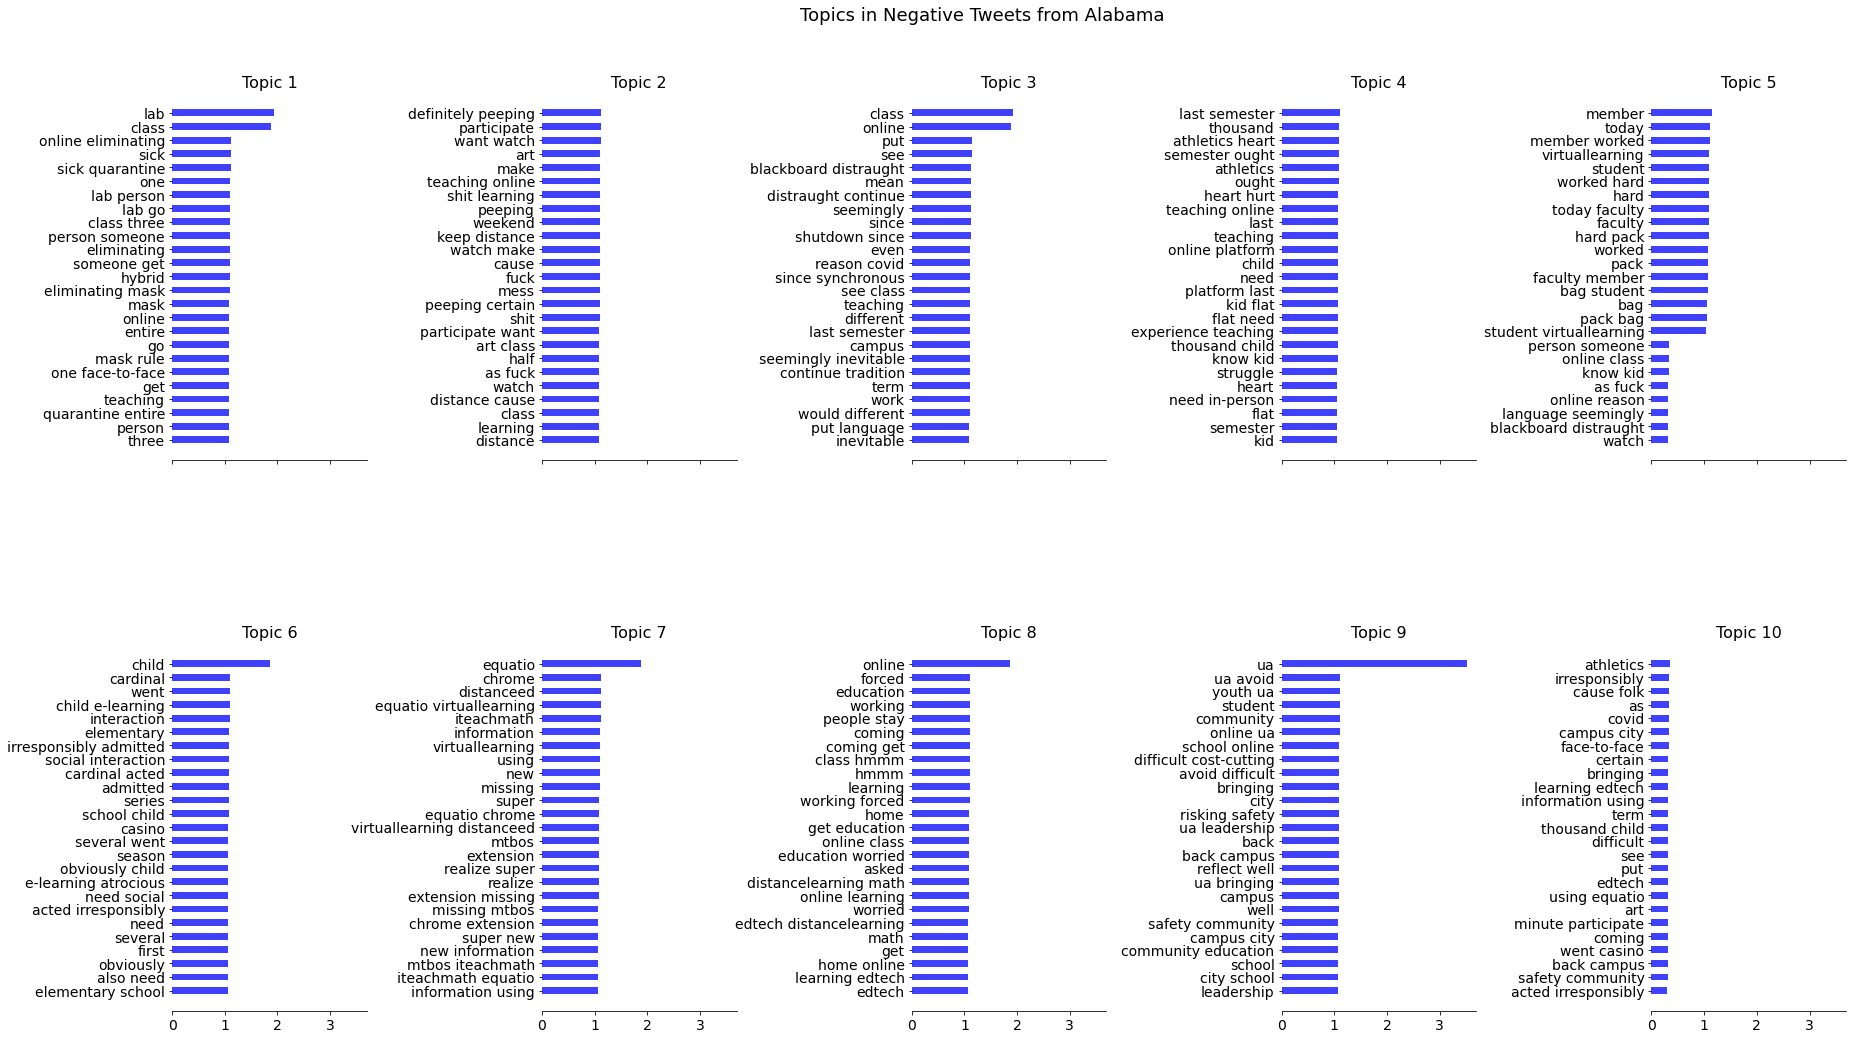

In [29]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[1], topic_num=10, top_word_count=25, plot_title='Topics in Negative Tweets from Alabama')

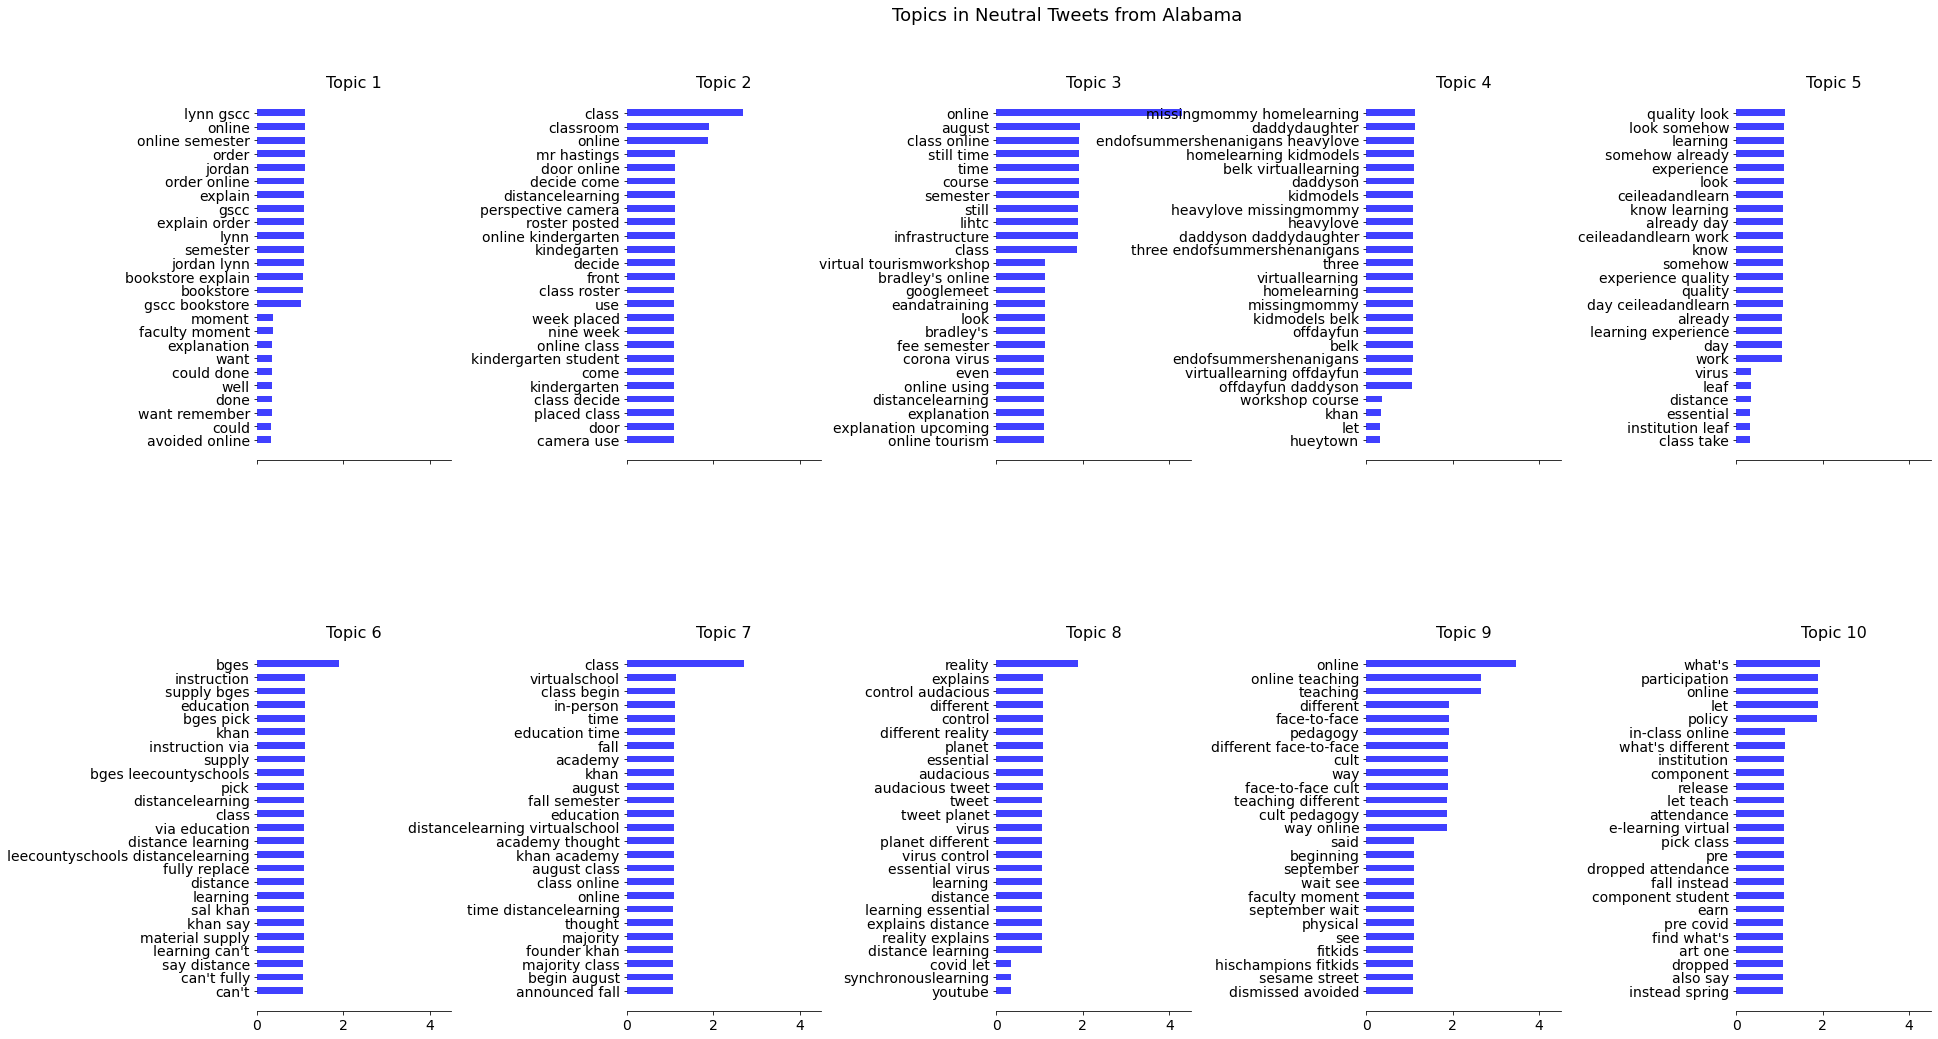

In [30]:
perform_topic_modeling_and_plot(content=alabama_sentiment_series[2], topic_num=10, top_word_count=25, plot_title='Topics in Neutral Tweets from Alabama')

## Question 4: Insights/Recommendations:
Insights:
* US:
    * Positive:
    * Negative:
    * Neutral:

* Southeast:
    * Positive:
    * Negative:
    * Neutral:

* Alabama: 
    * Positive:
    * Negative:
    * Neutral:

Recommendations:
* Topic Modeling complements the Sentiment Classifer and provides contextual insight into the words and terms that people are using in the various Positive, Negative or Neutral Tweets. Topic Modeling is an unsupervised learning technique doesn't have to be trained so it is faster and easier to generate than the Sentiment Classifier (which uses supervised learning requiring labeled data). I reccomend using Topic Modeling instead of Word Clouds based on frequent words/terms to provide a more organized method of presenting contextual insight.

* While this notebook only focuses in on a single Region and State, this process could be repeated for any Regions and/or States of interest. 

## Future Work:
* Create a dashboard/app that would allow the user to select specific Regions and/or States for Topic Modeling. Also allow for setting the desired number of topics and top word count. 